In [1]:
import pandas as pd
import os 
import scanpath as scp
import math
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def get_file_data(file):
    file_path = os.path.join('./data/scanpaths/', file)
    df = pd.read_csv(file_path, delimiter='\t')
    cols = df.columns.to_list()
    df['file'] = file.replace("_scanpath.tsv", "")
    df = df[['file'] + cols]
    return df

In [3]:
files = [i for i in os.listdir('./data/scanpaths/')]
master_df = get_file_data(files[0])

for i  in  files[1:]:
    master_df = pd.concat([master_df, get_file_data(i)])

In [4]:
all_columns = ['file', 'fixation_index', 'text_domain', 'trial', 'acc_bq_1', 'acc_bq_2', 'acc_bq_3', 'acc_tq_1', 'acc_tq_2', 'acc_tq_3',
'fixation_duration', 'next_saccade_duration', 'previous_saccade_duration', 'version', 'line', 'roi', 'char_index_in_line', 
'original_fixation_index', 'is_fixation_adjusted', 'reader_id', 'text_id', 'fixation_position_x', 'fixation_position_y',
'word_index_in_text', 'sent_index_in_text', 'char_index_in_text', 'word', 'character', 'text_id_numeric']

## Plot scanpaths


In [5]:
def plot_fixations(axs, scanpath, coordinate, color):
    # Sample data (time, x position, duration)
    time = scanpath['cum_fixation_duration'].to_list()
    if coordinate == "y":
        position = scanpath['fixation_position_y'].to_list()
    else:
        position = scanpath['fixation_position_x'].to_list()
    duration = scanpath['fixation_duration'].to_list()

    # Plot the horizontal lines
    list1 = []
    list2 = []
    for i in range(len(time)):
        list1.extend([position[i], position[i]])
        list2.extend([time[i], time[i] + duration[i]])
    axs.plot(list1, list2, color=color[0])

    for i in range(len(time)):
        axs.vlines(x=position[i], ymin=time[i], ymax=time[i] + duration[i], color=color[1])    

    # Add labels and title
    axs.set_ylabel('Time')
    if coordinate == "x":
        axs.set_xlabel('X Position')
    else:
        axs.set_xlabel('Y Position')
    return axs


def plot_scanpaths(axs, scanpathlist):
    color_comb = [('blue', 'red'), ('green', 'red'), ('purple', 'red') ]
    axs[0, 0] = plot_fixations(axs[0, 0], scanpathlist[0], "x", color_comb[0])
    axs[0, 1] = plot_fixations(axs[0, 1], scanpathlist[1], "x", color_comb[1])
    axs[1, 0] = plot_fixations(axs[1, 0], scanpathlist[0], "y", color_comb[0])
    axs[1, 1] = plot_fixations(axs[1, 1], scanpathlist[1], "y", color_comb[1])
    return axs



def plot_alignments_component(axs, scanpath, scanno, coordinate, color):

    # time = scanpath['cum_fixation_duration' + "_" + scanno].to_list()
    # duration = scanpath['fixation_duration'+ "_" + scanno].to_list()

    time = list(range(scanpath.shape[0]))
    duration = np.ones(shape= alignment.shape[0]).tolist()
    if coordinate == "y":
        position = scanpath['fixation_position_y'+ "_" + scanno].to_list()
    else:
        position = scanpath['fixation_position_x'+ "_" + scanno].to_list()

    # Plot the horizontal lines
    list1 = []
    list2 = []
    for i in range(len(time)):
        list1.extend([position[i], position[i]])
        list2.extend([time[i], time[i] + duration[i]])
    axs.plot(list1, list2, color=color[0])

    for i in range(len(time)):
        axs.vlines(x=position[i], ymin=time[i], ymax=time[i] + duration[i], color=color[1])    

    # Add labels and title
    axs.set_ylabel('Steps')
    if coordinate == "x":
        axs.set_xlabel('X Position')
    else:
        axs.set_xlabel('Y Position') 

    return axs

def plot_alignments(axs, alignment):
    color_comb = [('blue', 'red'), ('green', 'red'), ('purple', 'red') ]
    axs[0, 2] = plot_alignments_component(axs[0, 2], alignment, "s", 'x', color_comb[0])
    axs[0, 3] = plot_alignments_component(axs[0, 3], alignment, "t", 'x', color_comb[1])
    axs[0, 4] = plot_alignments_component(axs[0, 4], alignment, "s", 'x', color_comb[0])
    axs[0, 4] = plot_alignments_component(axs[0, 4], alignment, "t", 'x', color_comb[1])

    axs[1, 2] = plot_alignments_component(axs[1, 2], alignment, "s", 'y', color_comb[0])
    axs[1, 3] = plot_alignments_component(axs[1, 3], alignment, "t", 'y', color_comb[1])
    axs[1, 4] = plot_alignments_component(axs[1, 4], alignment, "s", 'y', color_comb[0])
    axs[1, 4] = plot_alignments_component(axs[1, 4], alignment, "t", 'y', color_comb[1])
    return axs


## Process scanpaths

In [6]:
def get_scanpath(scan_record):
    scanpath = master_df[master_df['file'] == scan_record]
    scanpath = scanpath[['fixation_index', 'fixation_duration', 'next_saccade_duration', 'previous_saccade_duration', 'line', 'char_index_in_line',
                    'fixation_position_x', 'fixation_position_y', 'word_index_in_text', 'sent_index_in_text', 'char_index_in_text']]
    scanpath['change_in_word_flag'] = (scanpath['word_index_in_text'].diff() == 0).astype(int).shift(-1)
    scanpath['change_in_word'] = (scanpath['change_in_word_flag'] == 0).cumsum().shift(1).fillna(0)
    scanpath['same_word_next_saccade_duration'] = scanpath['change_in_word_flag']*scanpath['next_saccade_duration']
    scanpath['next_saccade_duration'] = scanpath['next_saccade_duration'] - scanpath['same_word_next_saccade_duration']
    scanpath['fixation_duration'] = scanpath['same_word_next_saccade_duration'] + scanpath['fixation_duration']
    scanpath = scanpath.drop('same_word_next_saccade_duration', axis =1)
    scanpath = scanpath.groupby(['change_in_word', 'word_index_in_text']).aggregate({'fixation_duration':'sum', 'next_saccade_duration':'sum', 'fixation_position_x':'mean', 'fixation_position_y':'mean'}).reset_index()
    scanpath['cum_fixation_duration'] = scanpath['fixation_duration'].cumsum().shift(1).fillna(0)
    scanpath = scanpath.reset_index()
    return scanpath

/Users/RSingh81/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


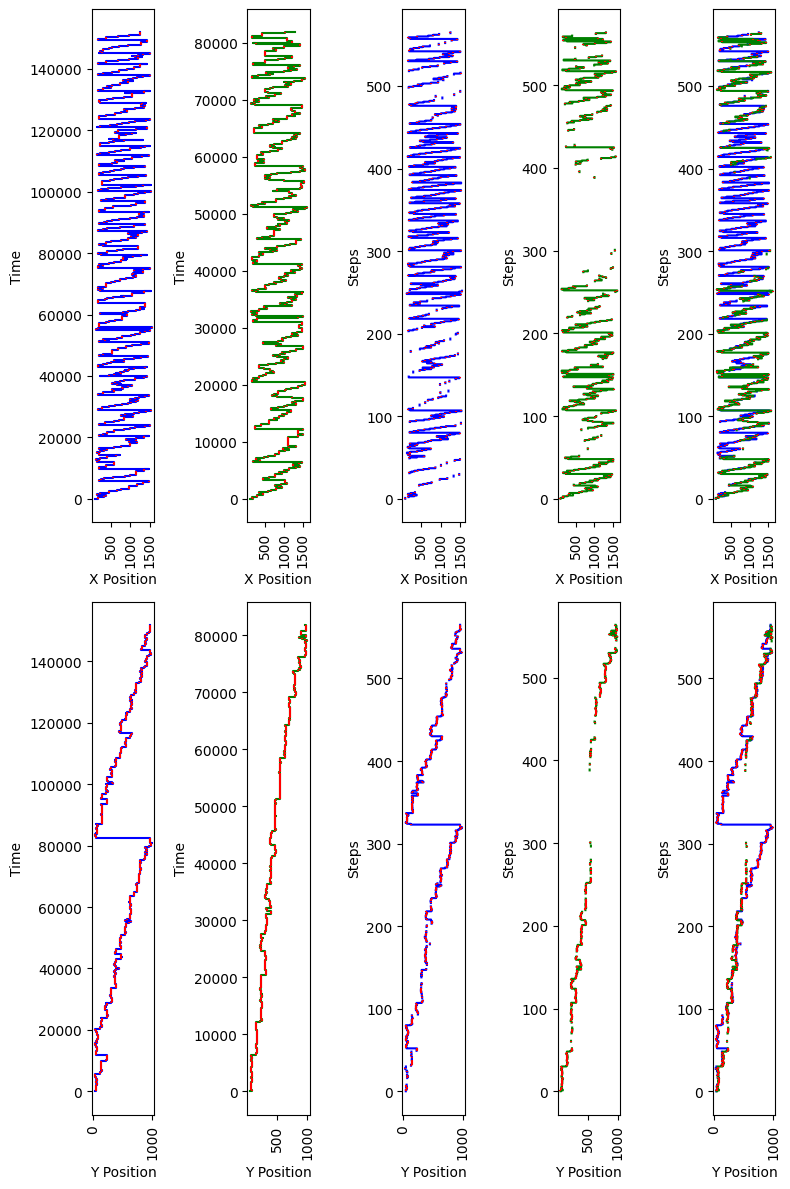

In [15]:
center_x = 840
center_y = 525
distance = 61
unit = 0.0282
scanpath1 = get_scanpath('reader70_p5')
scanpath2 = get_scanpath('reader71_p5')

score, path, alignment  = scp.rscasim(scanpath1, scanpath2, center_x, center_y, distance, unit, modulator=0.83)
# alignment = alignment.drop(0, axis=0).reset_index(drop=True)
alignment = alignment.merge(scanpath1[['index', 'fixation_position_x', 'fixation_position_y', 'fixation_duration', 'cum_fixation_duration']], left_on='s', right_on='index', how='left').rename(columns={'fixation_position_x':'fixation_position_x_s', 'fixation_position_y':'fixation_position_y_s',                                                                                                                                                                                         'fixation_duration':'fixation_duration_s', 'cum_fixation_duration':'cum_fixation_duration_s'}).drop('index', axis=1)
alignment = alignment.merge(scanpath2[['index', 'fixation_position_x', 'fixation_position_y', 'fixation_duration', 'cum_fixation_duration']], left_on='t', right_on='index', how='left').rename(columns={'fixation_position_x':'fixation_position_x_t', 'fixation_position_y':'fixation_position_y_t',
                                                                                                                                                                                                         'fixation_duration':'fixation_duration_t', 'cum_fixation_duration':'cum_fixation_duration_t'}).drop('index', axis=1)

fig, axs = plt.subplots(2, 5, figsize=(8, 12))
axs = plot_scanpaths(axs, [scanpath1, scanpath2])
axs = plot_alignments(axs, alignment)

for ax in axs:
    for axx in ax:
        axx.tick_params(axis='x', rotation=90)

plt.tight_layout()
fig.tight_layout()

In [12]:
all_columns = ['file', 'fixation_index', 'text_domain', 'trial', 'acc_bq_1', 'acc_bq_2', 'acc_bq_3', 'acc_tq_1', 'acc_tq_2', 'acc_tq_3',
'fixation_duration', 'next_saccade_duration', 'previous_saccade_duration', 'version', 'line', 'roi', 'char_index_in_line', 
'original_fixation_index', 'is_fixation_adjusted', 'reader_id', 'text_id', 'fixation_position_x', 'fixation_position_y',
'word_index_in_text', 'sent_index_in_text', 'char_index_in_text', 'word', 'character', 'text_id_numeric']

In [16]:
files = master_df['file'].unique()
texts = master_df['text_id'].unique()
persons = master_df['reader_id'].unique()

center_x = 840
center_y = 525
distance = 61
unit = 0.0282

files = files
files = [i for i in files if 'p0' in i]
file_count = len(files)
print(files, file_count)
simmilarity_matrix = np.zeros(shape=(file_count, file_count))

for i in range(file_count):
    scanpath1 = get_scanpath(files[i])
    for j in range(file_count):
        if j <= i:
            scanpath2 = get_scanpath(files[j])
            score, path, alignment  = scp.rscasim(scanpath1, scanpath2, center_x, center_y, distance, unit, modulator=0.83)
            alignment = alignment[alignment['cost'] >= 0]
            simmilarity_matrix[i, j] = alignment['cost'].sum()
            simmilarity_matrix[j, i] = alignment['cost'].sum()

['reader85_p0', 'reader23_p0', 'reader1_p0', 'reader64_p0', 'reader40_p0', 'reader72_p0', 'reader35_p0', 'reader93_p0', 'reader101_p0', 'reader16_p0', 'reader94_p0', 'reader32_p0', 'reader75_p0', 'reader63_p0', 'reader6_p0', 'reader19_p0', 'reader82_p0', 'reader17_p0', 'reader8_p0', 'reader100_p0', 'reader74_p0', 'reader95_p0', 'reader7_p0', 'reader18_p0', 'reader83_p0', 'reader62_p0', 'reader65_p0', 'reader84_p0', 'reader0_p0', 'reader22_p0', 'reader41_p0', 'reader34_p0', 'reader92_p0', 'reader73_p0', 'reader10_p0', 'reader76_p0', 'reader31_p0', 'reader97_p0', 'reader15_p0', 'reader102_p0', 'reader81_p0', 'reader5_p0', 'reader60_p0', 'reader79_p0', 'reader98_p0', 'reader39_p0', 'reader67_p0', 'reader2_p0', 'reader20_p0', 'reader105_p0', 'reader68_p0', 'reader12_p0', 'reader90_p0', 'reader36_p0', 'reader71_p0', 'reader38_p0', 'reader3_p0', 'reader87_p0', 'reader66_p0', 'reader13_p0', 'reader104_p0', 'reader69_p0', 'reader70_p0', 'reader91_p0', 'reader37_p0', 'reader30_p0', 'reader96_p0

/Users/RSingh81/Documents/personal_projects/scanpath/scanpath.py:77: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(np.sin(sb) * np.sin(tb) + np.cos(sb) * np.cos(tb) * np.cos(sa - ta)) * (180/np.pi)
/Users/RSingh81/Documents/personal_projects/scanpath/scanpath.py:77: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(np.sin(sb) * np.sin(tb) + np.cos(sb) * np.cos(tb) * np.cos(sa - ta)) * (180/np.pi)
/Users/RSingh81/Documents/personal_projects/scanpath/scanpath.py:77: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(np.sin(sb) * np.sin(tb) + np.cos(sb) * np.cos(tb) * np.cos(sa - ta)) * (180/np.pi)


In [ ]:
simmilarity_matrix_df = pd.DataFrame(data = simmilarity_matrix, columns=files, index=files)
simmilarity_matrix_df = simmilarity_matrix_df.iloc[:15, :15]
simmilarity_matrix_df_norm = (simmilarity_matrix_df - simmilarity_matrix_df.min().min()) / (simmilarity_matrix_df.max().max() - simmilarity_matrix_df.min().min())
no_cluster = 3
files_cluster = [(files[i], i) for i in range(file_count)]
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering( n_clusters=None, affinity='precomputed', linkage='average', distance_threshold=0.2)
cluster_labels = agg.fit_predict(simmilarity_matrix_df_norm)


In [ ]:
cluster_labels

,reader85_p0,reader23_p0,reader1_p0,reader64_p0,reader40_p0,reader72_p0,reader35_p0,reader93_p0,reader101_p0,reader16_p0,reader94_p0,reader32_p0,reader75_p0,reader63_p0,reader6_p0
reader85_p0,16873.168862,99945.989791,112047.428517,124272.535652,159465.512667,143125.413910,113757.799712,116159.005702,101892.870520,116367.503198,100194.293450,116003.954246,126966.200374,101462.586181,104907.559518
reader23_p0,99945.989791,8848.006053,71051.307313,82731.522843,131674.722162,113932.998176,70337.002288,108609.303780,57069.502023,89471.361385,96902.043679,86378.462754,84985.457962,58121.204299,62285.404968
reader1_p0,112047.428517,71051.307313,6354.005448,83447.081669,127955.733320,111451.410510,67495.923663,124199.522044,57792.740645,177812.766171,112944.188765,84913.456400,87011.080765,59481.526220,63082.775020
reader64_p0,124272.535652,82731.522843,83447.081669,8238.007631,140048.135996,119336.150909,79059.932267,131883.191313,71773.397484,102490.289263,120155.064260,93177.230964,177689.637368,72494.042614,71220.384553
reader40_p0,159465.512667,131674.722162,127955.733320,140048.135996,19112.807305,255165.527914,190656.190755,164682.564200,122081.651230,131346.067306,167683.618577,136598.524696,145913.632757,122239.040230,121014.838198
reader72_p0,143125.413910,113932.998176,111451.410510,119336.150909,255165.527914,17132.188216,109051.720254,150749.675338,99956.051711,124971.605760,144217.236869,111651.821879,127586.684948,97481.544377,98285.253731
reader35_p0,113757.799712,70337.002288,67495.923663,79059.932267,190656.190755,109051.720254,6080.005587,119092.853190,55642.648771,86645.959238,109474.836525,80869.891774,83696.058377,58467.009996,59082.169646
reader93_p0,116159.005702,108609.303780,124199.522044,131883.191313,164682.564200,150749.675338,119092.853190,16610.863294,108884.425414,129287.642584,109310.684641,127125.983322,135562.334485,109988.805916,112800.550724
reader101_p0,101892.870520,57069.502023,57792.740645,71773.397484,122081.651230,99956.051711,55642.648771,108884.425414,5603.601670,76530.892872,96272.035196,68735.973223,74709.367778,38758.615835,45577.312489
reader16_p0,116367.503198,89471.361385,177812.766171,102490.289263,131346.067306,124971.605760,86645.959238,129287.642584,76530.892872,9813.405282,124967.369151,96645.707793,101067.600355,76800.281538,79052.627537
